<div>
<font color=white size=5>
Loading Original Signal:
</div>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io.wavfile import read, write
import scipy.io.wavfile as wav
from scipy.signal import iirnotch , filtfilt , firwin , lfilter
import sounddevice as sd
load="C://Users//LENOVO//Desktop//Daneshgah//Signal//Group2//Recordings//Project_voice.wav"#to run the code,change this address to your address.
fs, original = read(load) #Return the sample rate , data from  WAV file
original = original.astype(np.float32) #making the signal mono
if (original.ndim > 1):
    original = original[:, 0]
max = np.max(np.abs(original)) #normalize , better processing and plotting
if (max != 0 ):
    original /= max

<div>
<font color=white size=5>
Required functions:
</div>

In [2]:
def add_noise_50(original, fs):#function to add power line noise 
    return original + (0.8 *np.sin(100*np.pi*np.arange(len(original))/fs))

def adaptive_lms(d,x,mu,M):
    # x is refrence signal noise
    # d is the input of signal that is noisy beacuse of power line noise
    #mu is the learning rate 
    #M is the memory of filter
    # y is the out put of the filter which is the input with less noise
    # you can find more details and explantion in the report file
    N = len(d)
    w = np.zeros(M)
    y = np.zeros(N)
    e = np.zeros(N)
    for i in range(M, N):
        x_1 = np.flip(x[i - M:i])
        y_n = 0.0
        for j in range(M):
            y_n += w[j] * x_1[j]
        e[i] = d[i] - y_n
        y[i] = e[i]
        for j in range(M):
            w[j] += 2* mu*e[i]*x_1[j]
    return y 

def play_audio(signal, sample_rate):

    #Plays an audio signal from an array,corresponding to a .wav file

    # Normalizing signal:
    signal = signal / np.max(np.abs(signal))
    
    # Play the audio
    sd.play(signal, samplerate=sample_rate)
    sd.wait()

<div>
<font color=white size=5>
Adaptive Filtering:
</div>

In [3]:
signal_with_noise= add_noise_50(original, fs)

# making signal refrence noise
t = np.arange(len(signal_with_noise))/fs
ref = np.sin(100*np.pi*t)
# filtering process
output_AdaptiveFilter = adaptive_lms(signal_with_noise, ref,0.001,32)

#saving
DeNoisePath="C://Users//LENOVO//Desktop//Daneshgah//Signal//Group2//Recordings//DeNoisedVoice_AdaptiveFilter.wav"
output_norm = output_AdaptiveFilter / np.max(np.abs(output_AdaptiveFilter))
write(DeNoisePath, fs, (output_norm * 32767).astype(np.int16))


<div>
<font color=white size=5>
IIR Filtering:
</div>

In [4]:
fs, original = read("C://Users//LENOVO//Desktop//Daneshgah//Signal//Group2//Recordings//Project_voice.wav") #Return the sample rate , data from  WAV file
original = original.astype(np.float32) #making the signal mono
if (original.ndim > 1):
    original = original[:, 0]
max = np.max(np.abs(original)) #normalize , better processing and plotting
if (max != 0 ):
    original /= max #add_noise function gets normalized signals as input

#function to add power line noise 
signal_with_noise= add_noise_50(original, fs)
if (max != 0 ):
    signal_with_noise=max*signal_with_noise



NoisePath="C://Users//LENOVO//Desktop//Daneshgah//Signal//Group2//Recordings//NoisyVoice.wav"
wav.write(NoisePath, fs, signal_with_noise.astype(np.int16)) #Here we load the Powerline Noise On the signal

#IIR Filtering:

Fs, noisySignal = wav.read("C://Users//LENOVO//Desktop//Daneshgah//Signal//Group2//Recordings//NoisyVoice.wav") #Return the sample rate , data from  WAV file
Q = 30.0  # Quality factor of the notch filter
w0 = 2*50/Fs  # Normalized frequency for iirnotch command

# Designing notch filter:
b, a = iirnotch(w0, Q)

signal_filtered_IIR = filtfilt(b, a, noisySignal)
DeNoisePath="C://Users//LENOVO//Desktop//Daneshgah//Signal//Group2//Recordings//DeNoisedVoice_IIR.wav"
wav.write(DeNoisePath, Fs, signal_filtered_IIR.astype(np.int16))

<div>
<font color=white size=5>
FIR Filtering:
</div>

In [5]:
fs, original = read("C://Users//LENOVO//Desktop//Daneshgah//Signal//Group2//Recordings//Project_voice.wav") #Return the sample rate , data from  WAV file
original = original.astype(np.float32) #making the signal mono
if (original.ndim > 1):
    original = original[:, 0]
max = np.max(np.abs(original)) #normalize , better processing and plotting
if (max != 0 ):
    original /= max #add_noise function gets normalized signals as input

#function to add power line noise 
signal_with_noise= add_noise_50(original, fs)
if (max != 0 ):
    signal_with_noise=max*signal_with_noise


NoisePath="C://Users//LENOVO//Desktop//Daneshgah//Signal//Group2//Recordings//NoisyVoice.wav"
wav.write(NoisePath, fs, signal_with_noise.astype(np.int16))
myfs=fs
stopband=[48,52]
fir_coeff = firwin(1001, stopband , pass_zero='bandstop',fs=myfs) #firwin creates an FIR filter using window method;
                                                                  #the first parameter is numtamps,i.e. the degree of the filter+1
                                                                #and it better be an odd number,stopband is the band we want to filter
                                                                 #and pass_zero determines the type of filter,which is notch or bandstop in this case
signal_filtered_FIR = lfilter(fir_coeff, 1.0, signal_with_noise)
DeNoisePath="C://Users//LENOVO//Desktop//Daneshgah//Signal//Group2//Recordings//DeNoisedVoice_FIR.wav"
wav.write(DeNoisePath, fs, signal_filtered_FIR.astype(np.int16))

<div>
<font color=white size=5>
Plotting Original,Noisy and Filtered Signals:
</div>

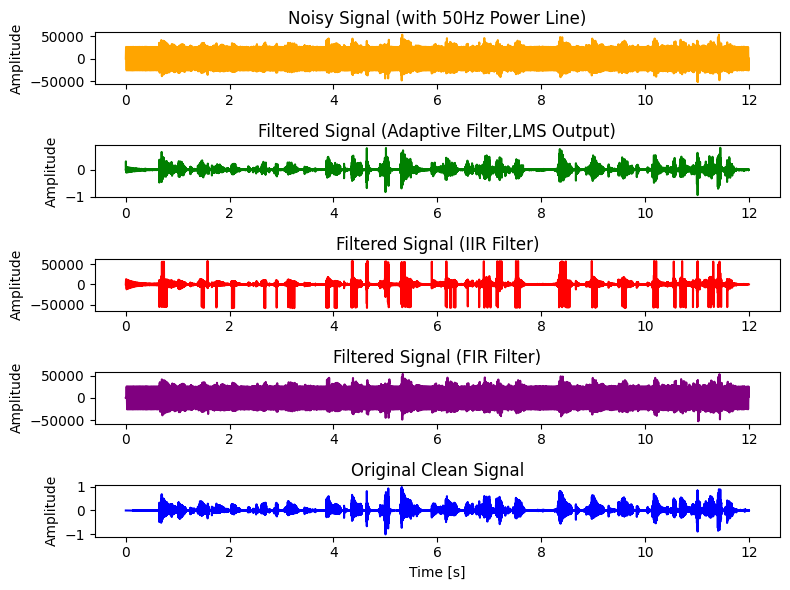

In [6]:
sec = np.arange(len(original)) / fs
end = min(int(fs * 12), len(original))

plt.figure(figsize=(8, 6))
plt.subplot(5, 1, 1)
plt.plot(sec[:end], signal_with_noise[:end], color='orange')
plt.title("Noisy Signal (with 50Hz Power Line)")
plt.ylabel("Amplitude")
plt.subplot(5, 1, 2)
plt.plot(sec[:end], output_AdaptiveFilter[:end], color='green')
plt.title("Filtered Signal (Adaptive Filter,LMS Output)")
plt.ylabel("Amplitude")
plt.subplot(5, 1, 3)
plt.plot(sec[:end], signal_filtered_IIR[:end], color='red')
plt.title("Filtered Signal (IIR Filter)")
plt.ylabel("Amplitude")
plt.subplot(5, 1, 4)
plt.plot(sec[:end], signal_filtered_FIR[:end], color='purple')
plt.title("Filtered Signal (FIR Filter)")
plt.ylabel("Amplitude")
plt.subplot(5, 1, 5)
plt.plot(sec[:end], original[:end], color='blue')
plt.title("Original Clean Signal")
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.tight_layout()
plt.show()


<div>
<font color=white size=5>
Play Signals:
</div>

In [7]:
#Uncomment each one you like!

play_audio(original,fs)
#play_audio(noisySignal,fs)
#play_audio(signal_filtered_FIR,fs)
#play_audio(signal_filtered_IIR,fs)
#play_audio(output_AdaptiveFilter,fs)